In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%gui qt

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))

import pathlib
import tifffile

import napari
from napari.utils.notebook_display import nbscreenshot

import delta

This notebook as been adapted from the documentation shown [here](https://delta.readthedocs.io/en/latest/usage/analysis.html)

We first download the processed data.

In [5]:
root = pathlib.Path(pathlib.Path.home(), 'I2ICourse')
processed_dir = root / 'ProcessedData'
processed_dir.mkdir(exist_ok=True)
data_url = 'https://drive.switch.ch/index.php/s/QG1z4Y5TXQIkNTa/download'

file_name = 'project1.zip'
file_path = str((processed_dir / file_name).resolve())


Uncomment the lines below to download the data

In [6]:
#!wget -q  -O $file_path $data_url
#!(cd $processed_dir && unzip -o -q $file_name)

We can now load the output data from Delta. Delta outputs a mp4 movie where you can check the segmentation and tracking result. You can open the movie from finder/explorer, you can find it here:

In [7]:
movie_dirs = sorted((root / 'ProcessedData' / 'project1').glob('*.mp4'))
print(movie_dirs[0])

/Users/simonvanvliet/I2ICourse/ProcessedData/project1/Position000000.mp4


We can now load the data again. 

To Load all data we can use the following command, but it can lead to memory issues and currently has a bug that gives issues when the data is stored in a custom folder

In [8]:
config_file = str((root / 'RawData' / 'project1' / 'config_2D_local.json').resolve())
delta.config.load_config(config_file)
reader = delta.utilities.xpreader(delta.config.eval_movie)

#the line below should normally reload all the data but now throws an error. In any case, it is memory hungry so you might want to laod data position by position
#processor = delta.pipeline.Pipeline(reader, reload=True, resfolder=str((root / 'ProcessedData' / 'project1').resolve()))


Loading configuration from: /Users/simonvanvliet/I2ICourse/RawData/project1/config_2D_local.json


Instead we will load a single position:

In [9]:
file_dirs = sorted((root / 'ProcessedData' / 'project1').glob('*.pkl'))
# this loads the processed data
pos = delta.pipeline.Position(None,None,None)
pos.load(file_dirs[0])
  


We can visualize using Napari:

In [10]:
imstack = np.stack(pos.rois[0].img_stack, axis=0)
labelstack = np.stack(pos.rois[0].label_stack, axis=0)


viewer = napari.view_image(imstack)
viewer.add_labels(labelstack)
viewer.show()



All tracking info is stored in the [lineage object](https://delta.readthedocs.io/en/latest/usage/utils_desc.html#lineage). 

> **Exercise** 
> 
> Read the lineage class documentation and check what kind of information is stored

Below we will show a few examples of how you can work with the lineage class.

First we will extract the lineage object from the position object and look at the number of cells present at the first frame

In [11]:
lin = pos.rois[0].lineage #get lineage for first region of interest (whole frame)

cell_0 = lin.cells[0]
print(cell_0.keys())


dict_keys(['id', 'mother', 'frames', 'daughters', 'new_pole', 'old_pole', 'edges', 'length', 'width', 'area', 'perimeter', 'sublin_id', 'unique_id', 'sibling', 'offspring1', 'offspring2', 'x_pos', 'y_pos'])


Next we will plot each cell’s length over time, with different colors for the first cells:

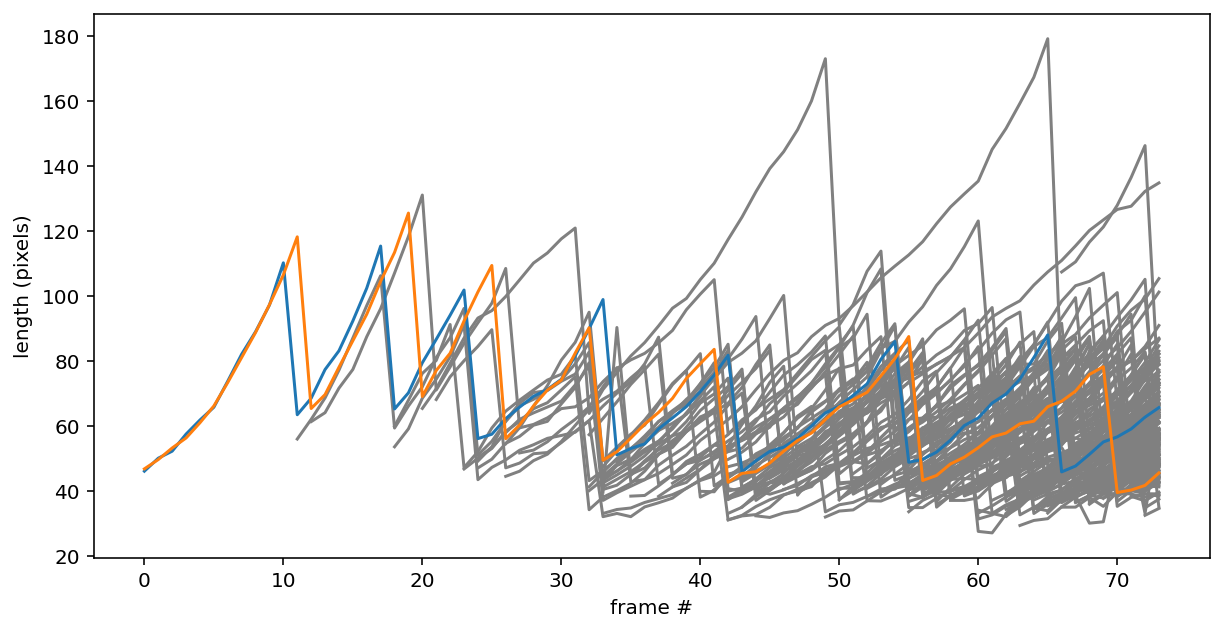

In [12]:
first_cells = lin.cellnumbers[0]

for cell in lin.cells:
    if cell['id'] not in first_cells:
        plt.plot(cell['frames'],cell['length'],color=[.5,.5,.5])

for cnb in first_cells:
    cell = lin.cells[cnb]
    plt.plot(cell['frames'],cell['length'])

plt.xlabel('frame #')
plt.ylabel('length (pixels)')
plt.show()    

You can also display which cells are descended from either of the first two cells on the last frame.

First define a function to retrieve which of the first two cells is the ancestor:


In [13]:
def which_first(lineage, cell_nb, first_cells):

    # Get cell dict:
    cell = lineage.cells[cell_nb]

    # If orphan or reached one of the first two cells:
    if cell['mother'] is None or cell['mother'] in first_cells:
        return cell['mother']

    # Otherwise go up the lineage tree:
    else:
        return which_first(lineage, cell['mother'], first_cells)

Then go over every cell of the last frame to reconstruct the image based on each cells’ ancestry:

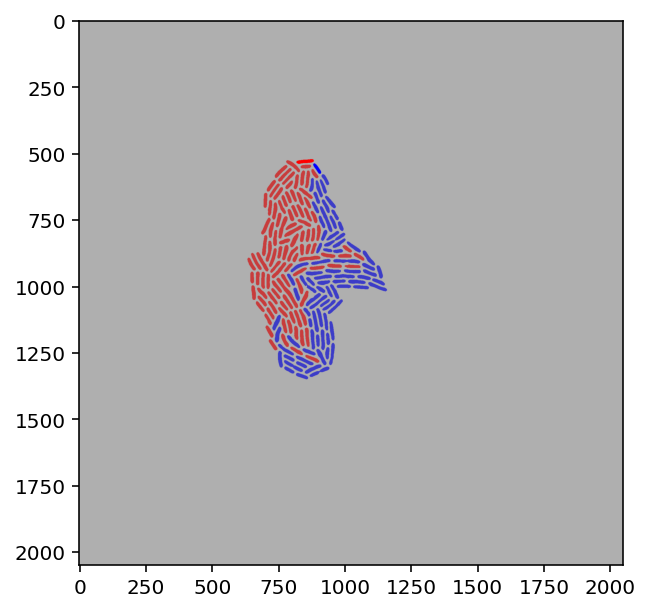

In [14]:
# Last labels frame:
labels = pos.rois[0].label_stack[-1]

#all cells present at first frame
first_cells = lin.cellnumbers[0]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

# Go over cells in last frame:
for cnb in lin.cellnumbers[-1]:

    # Which initial cell is ancestor?
    ancestor = which_first(lin, cnb, first_cells)

    # Pick color based on ancestor:
    if ancestor is None:
        if cnb==0:
            color=[255,0,0]
        elif cnb==1:
            color=[0,0,255]
        else:
            color=[0,0,0]
    elif ancestor==0:
        color=[200,60,60]
    elif ancestor==1:
        color=[60,60,200]

    # Color in the cell:
    for c, val in enumerate(color):
        color_image[:,:,c][labels==cnb+1]=val

plt.imshow(color_image)
plt.show()

Every package has it's own data format which makes data analysis hard if you use multiple of them. Here we thus convert the data to a standard format. Long-format table are well supported in general and are preferred by R / Panda etc.

Before doing that we have to add some extra lineage info:

In [15]:
def add_lineage_info(lineage):
#first we give each sublineage a unique id
    for idx, cell in enumerate(lin.cells):
        #keep track of division events
        div_event = np.array([d is not None for d in cell['daughters']])

        #create sublineage ID
        sublin_id = np.cumsum(div_event)
        sublin_id_list = sublin_id.tolist()

        #create unique cell id (id-sublin_id)
        unique_id = ['%i-%i' %(cell['id'], sid) for sid in sublin_id]

        #add offspring info
        d2_list = []
        [d2_list.append(d) for d in lin.cells[idx]['daughters'] if d is not None]
        d2_list.append(np.nan)

        d1_list = np.append(np.unique(sublin_id), np.nan)
        d1_id_list = ['%i-%i' %(cell['id'], d1) if ~np.isnan(d1) else np.nan for d1 in d1_list]

        d1 = [d1_id_list[idx+1] for idx in sublin_id_list]
        d2 = [d2_list[idx] for idx in sublin_id_list]

        lin.cells[idx]['sublin_id'] = sublin_id_list
        lin.cells[idx]['unique_id'] = unique_id

        lin.cells[idx]['sibling'] = lin.cells[idx]['daughters']
        lin.cells[idx]['offspring1'] = d1
        lin.cells[idx]['offspring2'] = d2
        
    return None
    

We can then convert the list of dictonaries to a pandas data frame:

In [16]:
add_lineage_info(lin)

df = pd.DataFrame(lin.cells)
df.head()

,id,mother,frames,daughters,new_pole,old_pole,edges,length,width,area,perimeter,sublin_id,unique_id,sibling,offspring1,offspring2,x_pos,y_pos
0,0,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[None, None, None, None, None, None, None, Non...","[[864, 931], [865, 920], [870, 911], [883, 897...","[[840, 930], [838, 919], [840, 913], [843, 906...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[46.0, 50.0, 52.16307067871094, 57.42223358154...","[14.0, 14.0, 15.61145305633545, 15.92080593109...","[565.0, 624.5, 688.0, 734.0, 772.0, 828.0, 932...","[25, 22, 28, 52, 61, 56, 66, 63, 81, 78, 89, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0-0, 0-0, 0-0, 0-0, 0-0, 0-0, 0-0, 0-0, 0-0, ...","[None, None, None, None, None, None, None, Non...","[0-1, 0-1, 0-1, 0-1, 0-1, 0-1, 0-1, 0-1, 0-1, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, ...","[930.7711038961039, 919.9219440353461, 912.734...","[851.672077922078, 853.0073637702503, 855.4624..."
1,1,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[None, None, None, None, None, None, None, Non...","[[918, 939], [928, 929], [929, 922], [929, 913...","[[890, 935], [891, 925], [898, 920], [891, 917...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[46.71253967285156, 49.583763122558594, 53.146...","[14.687394142150879, 14.687395095825195, 15.22...","[553.5, 585.0, 650.0, 686.5, 759.0, 839.5, 930...","[41, 46, 37, 47, 43, 55, 62, 74, 80, 88, 94, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1-0, 1-0, 1-0, 1-0, 1-0, 1-0, 1-0, 1-0, 1-0, ...","[None, None, None, None, None, None, None, Non...","[1-1, 1-1, 1-1, 1-1, 1-1, 1-1, 1-1, 1-1, 1-1, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, ...","[936.3190082644628, 926.3677621283255, 920.975...","[904.6280991735537, 909.3818466353678, 913.519..."
2,2,0.0,"[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...","[None, None, None, None, None, None, None, 5, ...","[[907, 855], [907, 853], [912, 847], [907, 842...","[[942, 848], [950, 845], [960, 842], [966, 841...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[55.899742126464844, 61.96061325073242, 68.553...","[14.688300132751465, 15.15165901184082, 15.162...","[665.0, 742.0, 816.0, 934.5, 1050.5, 1206.5, 1...","[52, 44, 49, 46, 42, 42, 42, 30, 32, 22, 30, 3...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, ...","[2-0, 2-0, 2-0, 2-0, 2-0, 2-0, 2-0, 2-1, 2-1, ...","[None, None, None, None, None, None, None, 5, ...","[2-1, 2-1, 2-1, 2-1, 2-1, 2-1, 2-1, 2-2, 2-2, ...","[5, 5, 5, 5, 5, 5, 5, 11, 11, 11, 11, 11, 11, ...","[851.2579310344828, 848.1373762376238, 844.073...","[925.063448275862, 929.1794554455446, 935.8224..."
3,3,1.0,"[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2...","[None, None, None, None, None, None, None, Non...","[[904, 875], [907, 871], [905, 866], [911, 863...","[[948, 864], [951, 861], [956, 859], [970, 859...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[61.252342224121094, 64.01649475097656, 71.566...","[14.946409225463867, 15.059335708618164, 14.60...","[707.0, 783.0, 855.0, 899.5, 1080.5, 1181.5, 1...","[67, 54, 45, 35, 44, 42, 40, 54, 55, 34, 61, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[3-0, 3-0, 3-0, 3-0, 3-0, 3-0, 3-0, 3-0, 3-0, ...","[None, None, None, None, None, None, None, Non...","[3-1, 3-1, 3-1, 3-1, 3-1, 3-1, 3-1, 3-1, 3-1, ...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 14, 14, 14, 14, 14...","[870.4637305699482, 866.5135135135135, 862.358...","[923.2784974093264, 926.8542890716803, 930.585..."
4,4,0.0,"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2...","[None, None, None, None, None, 8, None, None, ...","[[861, 847], [857, 845], [834, 845], [818, 846...","[[904, 853], [910, 852], [891, 848], [880, 844...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[59.83647918701172, 67.86607360839844, 76.1042...","[14.326173782348633, 14.802335739135742, 15.58...","[719.0, 813.5, 937.5, 1026.5, 1134.0, 576.0, 6...","[44, 55, 43, 50, 64, 37, 32, 47, 43, 42, 53, 5...","[0, 0, 0, 0, 0, 1, 1,

You can see that the dataframe contains nested data, but we can use the explode function to convert to long format:

In [17]:
#find all fields that have time dependent information
vector_data = []
[vector_data.append(key) for key in lin.cells[0].keys() if isinstance(lin.cells[0][key], list)]
print(vector_data)

#explode time into separate rows
df = df.explode(vector_data)
df.head()

['frames', 'daughters', 'new_pole', 'old_pole', 'edges', 'length', 'width', 'area', 'perimeter', 'sublin_id', 'unique_id', 'sibling', 'offspring1', 'offspring2', 'x_pos', 'y_pos']


,id,mother,frames,daughters,new_pole,old_pole,edges,length,width,area,perimeter,sublin_id,unique_id,sibling,offspring1,offspring2,x_pos,y_pos
0,0,NaN,0,None,"[864, 931]","[840, 930]",,46.0,14.0,565.0,25,0,0-0,None,0-1,2,930.771104,851.672078
0,0,NaN,1,None,"[865, 920]","[838, 919]",,50.0,14.0,624.5,22,0,0-0,None,0-1,2,919.921944,853.007364
0,0,NaN,2,None,"[870, 911]","[840, 913]",,52.163071,15.611453,688.0,28,0,0-0,None,0-1,2,912.734584,855.462466
0,0,NaN,3,None,"[883, 897]","[843, 906]",,57.422234,15.920806,734.0,52,0,0-0,None,0-1,2,902.762563,861.723618
0,0,NaN,4,None,"[889, 889]","[844, 899]",,61.759975,15.67858,772.0,61,0,0-0,None,0-1,2,894.429082,866.506555


Now we can use the power of Pandas dataframes to organize, manipulate, and plot the data.
For example we can extract the data for a given cell by searching for it's unique id:

In [18]:
df[df['unique_id'] == '0-1']

,id,mother,frames,daughters,new_pole,old_pole,edges,length,width,area,perimeter,sublin_id,unique_id,sibling,offspring1,offspring2,x_pos,y_pos
0,0,NaN,11,2,"[883, 857]","[837, 862]",,63.378334,15.214535,774.5,45,1,0-1,2,0-2,4,859.679335,862.953682
0,0,NaN,12,None,"[880, 857]","[832, 861]",,68.461487,15.172421,841.5,40,1,0-1,None,0-2,4,858.704918,858.382514
0,0,NaN,13,None,"[885, 854]","[830, 858]",,77.301109,14.525681,929.0,44,1,0-1,None,0-2,4,855.93274,857.85361
0,0,NaN,14,None,"[879, 854]","[819, 855]",,83.069839,14.304591,1032.5,29,1,0-1,None,0-2,4,854.585192,851.38537
0,0,NaN,15,None,"[884, 856]","[813, 853]",,92.258171,14.872062,1169.0,32,1,0-1,None,0-2,4,853.479874,848.315706
0,0,NaN,16,None,"[895, 854]","[811, 849]",,102.369095,16.449091,1275.0,54,1,0-1,None,0-2,4,849.9906,851.35141
0,0,NaN,17,None,"[891, 856]","[793, 850]",,115.326927,16.765436,1381.0,83,1,0-1,None,0-2,4,850.999334,842.561626


Moreover we can easily quantify average properties of cells, here we extract for example the life times of cells:

Text(0.5, 0, 'life time of cell (in frames')

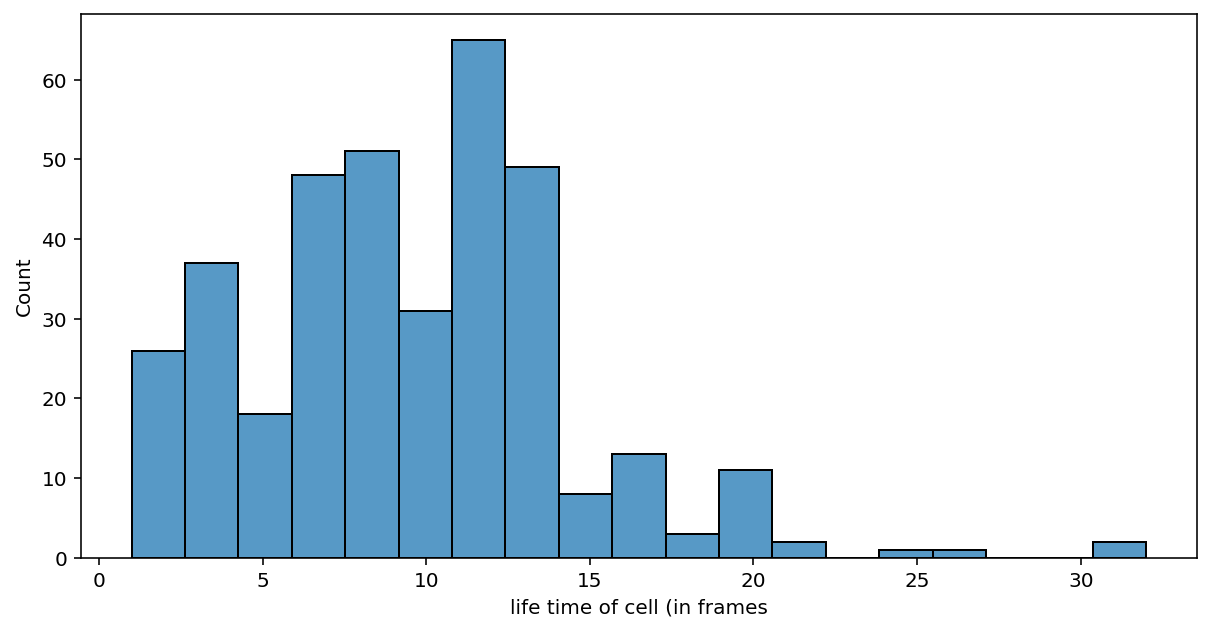

In [19]:
life_time_cell = df.groupby('unique_id').size()

import seaborn as sns
ax = sns.histplot(life_time_cell)
ax.set_xlabel('life time of cell (in frames')

And we can for example extract the first or last frame of each cell and look at it's properties at that time:

<AxesSubplot:xlabel='length', ylabel='length'>

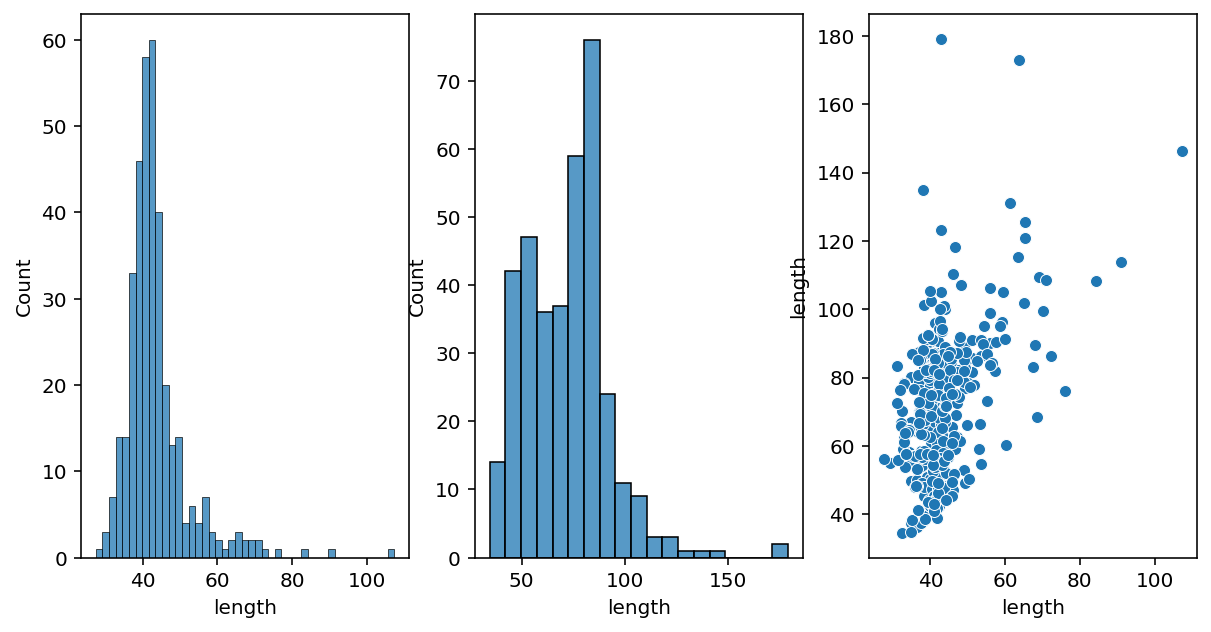

In [20]:
df_first_frame = df.groupby('unique_id').first()
df_last_frame = df.groupby('unique_id').last()


fig, axs = plt.subplots(1,3)
sns.histplot(ax=axs[0], data=df_first_frame, x='length')
sns.histplot(ax=axs[1], data=df_last_frame, x='length')
sns.scatterplot(ax=axs[2], x=df_first_frame['length'], y=df_last_frame['length'])
titles = ['length at birth', 'length at division', 'length at division vs length at birth'] 
for idx, title in enumerate(titles): axs[idx].set_title(title)


> ## Exercise 1
> 
> As you can see in the table, Delta does not extract the position of cells. 
> 
> Can you find a way to include this?
> 
> Hint:
> 
> - You can find the segmented data in labels = pos.rois[0].label_stack[t_idx]
> - Look back into the notebook from Project 1 on how to extract the cell position from the segmented image
> 
> You can modify the function add_segment_info the code below

In [21]:
from skimage.measure import regionprops

def add_segment_info(lin, label_stack):  
    
    rp = #add code here, create lists with each entry cell properties of all cells in a single frame
    
    label_lut = []
    for cell_nr in lin.cellnumbers:
        cell_nr = cell_nr.copy()
        cell_nr.sort()
        label_lut.append(cell_nr)

    for idx, cell in enumerate(lin.cells):        
        cell_idx = cell['id'] #the number cell has in label image
        cell_frames = cell['frames'] #the frame the cell exists
                
        x_pos = np.full(len(cell_frames), np.nan)
        y_pos = np.full(len(cell_frames), np.nan)
        
        for f_idx, frame in enumerate(cell_frames):
            rp_idx = label_lut[frame].index(cell_idx)
            centroid = rp[frame][rp_idx].centroid
            
            if len(centroid) == 2:
                x_pos[f_idx] = centroid[1]
                y_pos[f_idx] = centroid[0]
                
        lin.cells[idx]['x_pos'] = x_pos.tolist()
        lin.cells[idx]['y_pos'] = y_pos.tolist()
        
    return None

def lin_to_df(lin):
    #find vector based data
    vector_data = []
    [vector_data.append(key) for key in lin.cells[0].keys() if isinstance(lin.cells[0][key], list)]
    #create data frame
    df = pd.DataFrame(lin.cells)
    #explode time into separate rows
    df = df.explode(vector_data)
    return df



label_stack = pos.rois[0].label_stack
lin = pos.rois[0].lineage
add_lineage_info(lin)
add_segment_info(lin, label_stack)

df = lin_to_df(lin)
df.head()

,id,mother,frames,daughters,new_pole,old_pole,edges,length,width,area,perimeter,sublin_id,unique_id,sibling,offspring1,offspring2,x_pos,y_pos
0,0,NaN,0,None,"[864, 931]","[840, 930]",,46.0,14.0,565.0,25,0,0-0,None,0-1,2,930.771104,851.672078
0,0,NaN,1,None,"[865, 920]","[838, 919]",,50.0,14.0,624.5,22,0,0-0,None,0-1,2,919.921944,853.007364
0,0,NaN,2,None,"[870, 911]","[840, 913]",,52.163071,15.611453,688.0,28,0,0-0,None,0-1,2,912.734584,855.462466
0,0,NaN,3,None,"[883, 897]","[843, 906]",,57.422234,15.920806,734.0,52,0,0-0,None,0-1,2,902.762563,861.723618
0,0,NaN,4,None,"[889, 889]","[844, 899]",,61.759975,15.67858,772.0,61,0,0-0,None,0-1,2,894.429082,866.506555


Now let's visually check:

Text(0.5, 1.0, 'y-position center of cell')

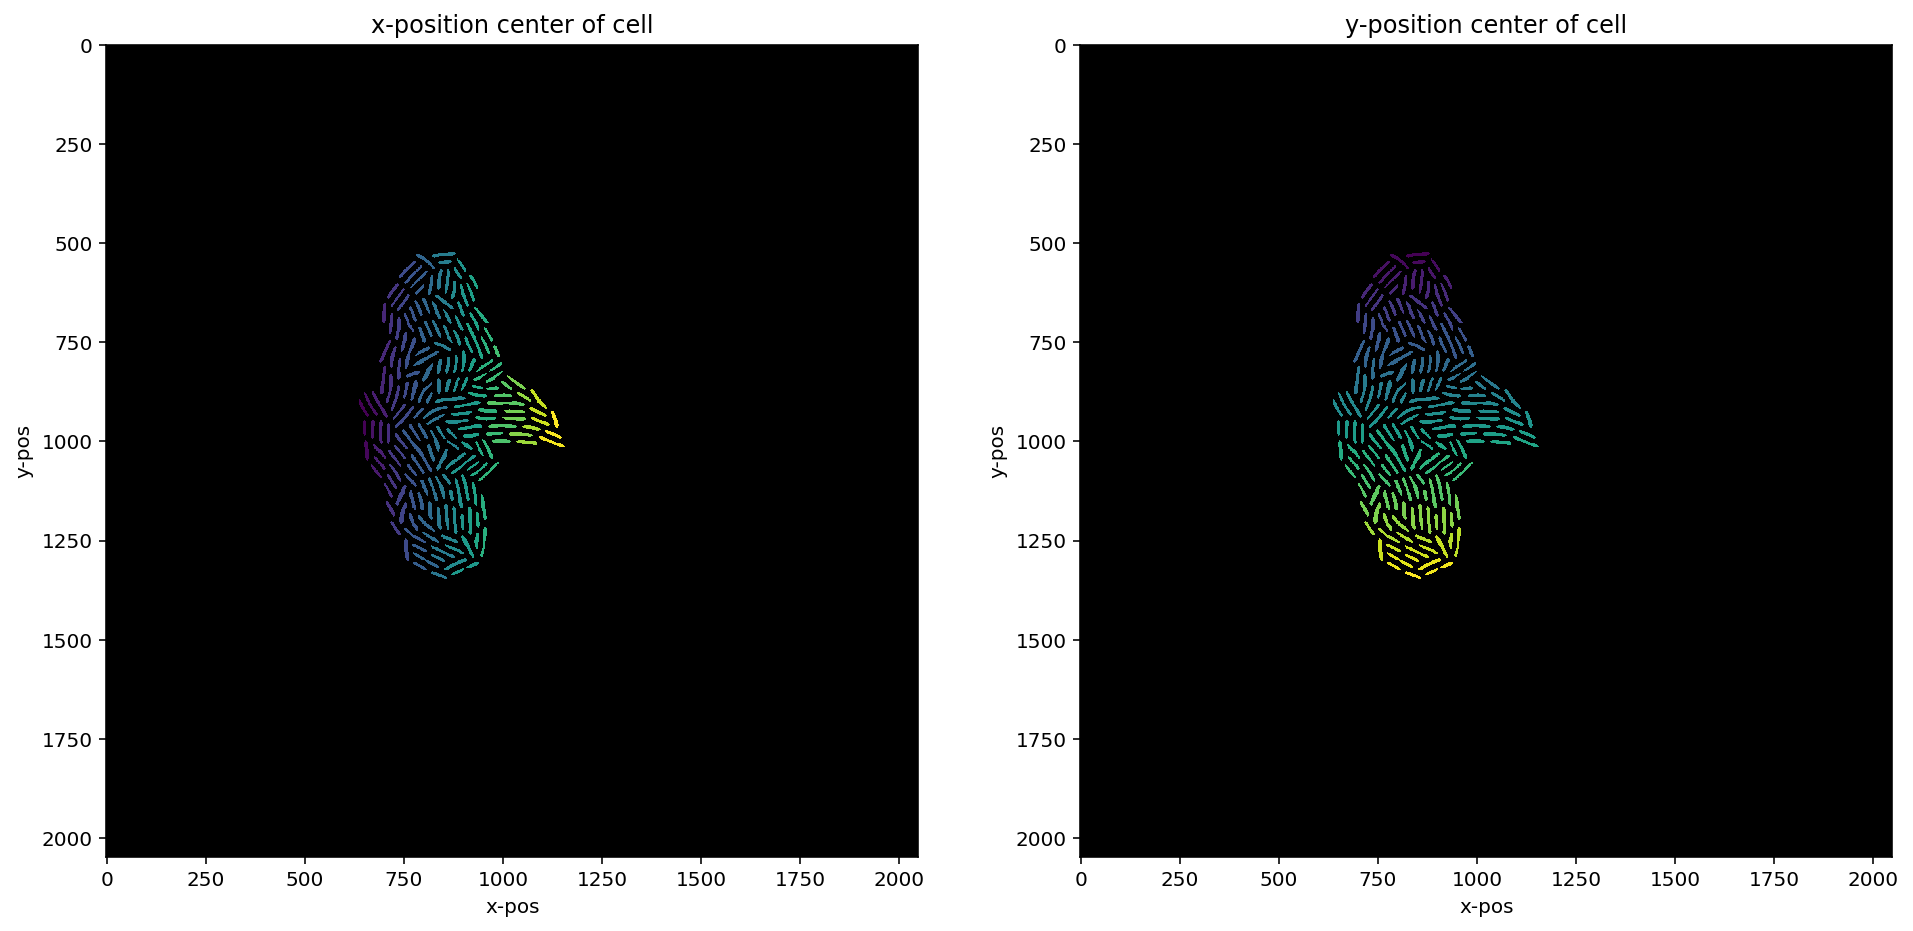

In [22]:
import matplotlib.cm as cm

colMap = cm.get_cmap("viridis").copy()
colMap.set_bad(color='black')

# Last labels frame:
labels = pos.rois[0].label_stack[-1]

x_im = np.full(labels.shape, np.nan)
y_im = np.full(labels.shape, np.nan)

# Go over cells in last frame:
for cnb in lin.cellnumbers[-1]:

   x_pos = lin.cells[cnb]['x_pos'][-1]
   y_pos = lin.cells[cnb]['y_pos'][-1]

   x_im[labels==cnb+1]=x_pos
   y_im[labels==cnb+1]=y_pos

fig, axs = plt.subplots(1,2, figsize=(16,24))
axs[0].imshow(x_im, cmap=colMap)
axs[1].imshow(y_im, cmap=colMap)    

[ax.set_xlabel('x-pos') for ax in axs] 
[ax.set_ylabel('y-pos') for ax in axs] 
axs[0].set_title('x-position center of cell')
axs[1].set_title('y-position center of cell')

We can save using:

In [29]:

pos.save(filename=file_dirs[0], save_format='pickle')
df_name = (file_dirs[0].name).replace('.pkl','_df.pkl')
save_name = root / 'ProcessedData' / 'project1' / df_name
df.to_pickle(save_name)


Wed Mar  9 20:44:29 2022, Position 0 - Saving to pickle format
/Users/simonvanvliet/I2ICourse/ProcessedData/project1/Position000000.pkl


## Excercises